# Sử dụng thư viện PyCaret để lựa chọn mô hình cho bộ dữ liệu phục vụ dự báo chuỗi thời gian

## 1. Chuẩn bị thư viện cần thiết và file đầu vào

In [1]:
import pandas as pd
import numpy as np
import pycaret
import plotly.express as px

from pycaret.time_series import *

In [2]:
xls = pd.ExcelFile("Bo-du-lieu-goc.xlsx")
# df = pd.read_excel(xls,'Sheet2', parse_dates=True, index_col="Timestamp")
df = pd.read_excel(xls,'Table1')
# df_index = pd.read_excel(xls,'Sheet2', parse_dates=True, index_col="Timestamp")

In [3]:
df.head()

,Timestamp,So luong
0,2022-06-13,2.0
1,2022-06-13,3.0
2,2022-06-13,1.0
3,2022-06-13,1.0
4,2022-06-13,1.0


## 2. Tiền xử lý

#### 2.1 Kiểm tra thuộc tính của dữ liệu

In [4]:
# Kiểm tra dạng dữ liệu chung và khuyết thiếu
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7187 entries, 0 to 7186
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Timestamp  7187 non-null   datetime64[ns]
 1   So luong   7186 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 112.4 KB


In [5]:
# Kiểm tra số ngày khác nhau và xác nhận thời gian cũ/mới nhất
df.Timestamp.describe()

count                    7187
unique                    320
top       2022-08-11 00:00:00
freq                      352
first     2022-06-13 00:00:00
last      2023-04-28 00:00:00
Name: Timestamp, dtype: object

**Đổi định dạng số nguyên và xóa giá trị khuyết thiếu**

In [6]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7186 entries, 0 to 7186
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Timestamp  7186 non-null   datetime64[ns]
 1   So luong   7186 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 168.4 KB


In [7]:
df['So luong'] = df['So luong'].astype(int)

In [8]:
df.rename(columns={'So luong':'Count'}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7186 entries, 0 to 7186
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Timestamp  7186 non-null   datetime64[ns]
 1   Count      7186 non-null   int32         
dtypes: datetime64[ns](1), int32(1)
memory usage: 140.4 KB


**Vì đang quan tâm một ngày bán được bao nhiêu sản phẩm, nên cần nhóm lại theo thời gian, không quan tâm đến sản phẩm cụ thể bán là gì nữa (do các sản phẩm ngày bán được ngày không, thực ra làm vẫn được tuy nhiên thời gian dữ liệu lại không trải dài). Vì vậy, thực hiện bài toán coi như đang bán 1 sản phẩm, cách xử lý bài toán vẫn tương tự.**

In [9]:
df_sales = df[['Timestamp','Count']].groupby(['Timestamp']).sum()
df_sales.rename(columns={'Count':'Sum'}, inplace=True)

In [10]:
df_sales

,Sum
Timestamp,
2022-06-13,17
2022-06-14,25
2022-06-15,128
2022-06-16,58
2022-06-17,22
...,...
2023-04-24,55
2023-04-25,31
2023-04-26,25


#### 2.2 Kiểm tra số ngày thiếu trong dữ liệu thời gian

In [11]:
# Tạo một khoảng thời gian tham chiếu
ref_dates = pd.date_range(start='2022-06-13', end='2023-04-28')

# Đánh lại chỉ số index cho khoảng thời gian
df_reindexed = df_sales.reindex(ref_dates)

# Kiểm tra thời gian thiếu
if df_reindexed.isnull().sum()[0] == 0:
    print("Không thiếu ngày nào")
else:
    print("Thiếu ngày")

Không thiếu ngày nào


## 3. Thiết lập môi trường và phân tích với PyCaret

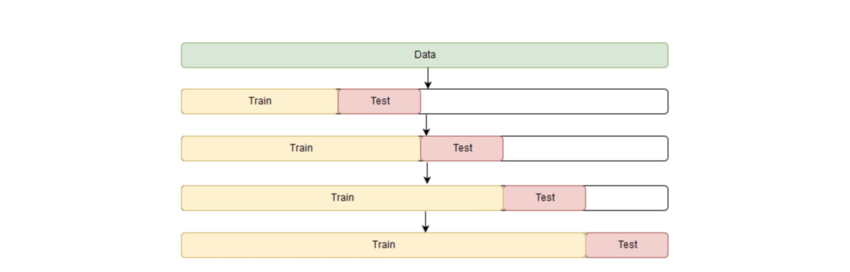

In [12]:
s = setup(df_sales, fh = 12, fold = 3, session_id = 123)
# fh: forecast horizon - số ngày muốn dự đoán tiếp theo
# fold: chia tệp thành 3 lần kiểm chéo với Expanding Window Cross-Validation như hình cho time-series
# session_id: giữ nguyên kết quả qua mỗi lần test (pseudo-random seed)
# ---
# Diễn giải một số trường kết quả
# Exogenous Variables: biến ngoại sinh/độc lập/đặc trưng đối với dạng bài multivarate
# Enforce Prediction Interval: thể hiện khoảng dự đoán của mô hình, tại đó các kết quả có khả năng rơi vào, do sự không chắc chắn của mô hình
# Seasonality Present: chỉ ra rằng tính thời vụ có trong tập dữ liệu
# Seasonal Period(s) Tested: chỉ định khoảng thời gian theo mùa tiềm năng sau khi đã test, [x] - x time point cho một season
# Recommended d: 1 - sử dụng kỹ thuật differencing để giúp dữ liệu đạt được tính stationary (tính dừng)
# Recommended Seasonal D: 0 - không cần sử dụng kỹ thuật để loại bỏ seasonal trong dữ liệu (do tính thời vụ không được thể hiện rõ ràng)
# ---
# Thông tin thêm
# Differencing: Là phương pháp để biến đổi một chuỗi time series thành chuỗi dừng (stationary), để loại bỏ xu hướng (trend), hay sự tự tương quan (auto-correlation)

,Description,Value
0,session_id,123
1,Target,Sum
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(320, 1)"
5,Transformed data shape,"(320, 1)"
6,Transformed train set shape,"(308, 1)"
7,Transformed test set shape,"(12, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


### 3.1 EDA - Khám phá và phân tích bộ dữ liệu

#### 3.1.1 Kết quả thống kê của bộ dữ liệu

In [13]:
check_stats()
# ---
# Diễn giải một vài trường dữ liệu
# Test: Summary - tổng thể trên trường dữ liệu, White Noise - nhiễu trắng, Stationarity - độ ổn định/tính dừng, Normailty - liên quan đến dạng phân bố chuẩn
# Test Name: các kỹ thuật để test
# Data: Transformed - dữ liệu được biến đổi qua bước setup() để phù hợp (differencing)
# --- Property
# Kurtosis: độ nhọn phân phối - > 0 là rất nhọn
# Skewness: lệch phải/trái phân bố (yếu vị, so sánh với mean và median), ở đây thấy 6.4 < 34 && 24 -> phân phối lệch dương, phân bổ nhiều bên trái
# http://thongke.cesti.gov.vn/dich-vu-thong-ke/tai-lieu-phan-tich-thong-ke/846-thong-ke-mo-ta-trong-nghien-cuu-dai-luong-hinh-dang-phan-phoi

# Ljung Box test for Autocorrelation
# Ljung Box test: kiểm định dữ liệu có tự tương quan (autocorrelation) hay không
# Tự tương quan: Mối tương quan giữa quan sát hiện tại và quan sát trễ (trước đó) trong một chuỗi thời gian
# Tự tương quan dương có nghĩa quan sát trước kéo theo quan sát sau đi lên, quan sát sau là hệ quả của quan sát trước
# Có thể biểu thị bằng biểu đồ tương quan. X biểu thị độ trễ và y biểu thị hệ số AC (-1 đến 1, 1 cho tương quan dương hoàn hảo)
# Sử dụng trong trường hợp xác định nhiễu, không có hiện tượng AC. Alpha: 0.05 - ngưỡng bác bỏ H0 (is AC), nếu nhỏ hơn 0.05, bác bỏ H0 -> không có AC
# K: 24 - độ trễ (lag) cần xem xét - sự cách biệt giữa các quan sát (how far back in time we are looking when comparing observations)
# -> Tóm lại, hiện tượng AC và White Noise có mối quan hệ nghịch đảo -> Có nhiều nhiễu thì mất đi sự tương quan, và khi test báo False tức là có sự tự tương quan ở một hoặc nhiều độ trễ
# Tự tương quan có ý nghĩa trước khi xây dựng Time Series Model 

# ADF for Stationarity
# https://nghiencuudinhluong.com/tinh-dung-cua-du-lieu-chuoi-thoi-gian-va-cac-kiem-dinh-tinh-dung/ 
# https://chaydinhluong.com/unit-root-test-tinh-dung-kiem-tra-tinh-on-dinh-du-lieu/ 
# chuỗi thời gian là dừng khi giá trị trung bình, phương sai, hiệp phương sai (tại các độ trễ khác nhau) 
# giữ nguyên không đổi cho dù chuỗi được xác định vào thời điểm nào đi nữa
# Chuỗi dừng có xu hướng trở về giá trị trung bình và những dao động quanh giá trị trung bình sẽ là như nhau
# -> sự thay đổi về thời gian không gây ra sự thay đổi về hình dạng của phân bố
# Nếu không ổn định sẽ gây ra hiện tượng hồi quy giả - nhận được giá trị bình phương r cao ngay cả khi dữ liệu không liên quan
# ADF bác bỏ giả thuyết không có tính dừng khi giá trị thống kê thấp hơn giá trị tới hạn


,Test,Test Name,Data,Property,Setting,Value
0,Summary,Statistics,Transformed,Length,,320.0
1,Summary,Statistics,Transformed,# Missing Values,,0.0
2,Summary,Statistics,Transformed,Mean,,34.909375
3,Summary,Statistics,Transformed,Median,,24.0
4,Summary,Statistics,Transformed,Standard Deviation,,48.408993
5,Summary,Statistics,Transformed,Variance,,2343.430633
6,Summary,Statistics,Transformed,Kurtosis,,61.325811
7,Summary,Statistics,Transformed,Skewness,,6.45665
8,Summary,Statistics,Transformed,# Distinct Values,,88.0
9,White Noise,Ljung-Box,Transformed,Test Statictic,"{'alpha': 0.05, 'K': 24}",78.032281


#### 3.1.2 Vẽ biểu đồ dữ liệu gốc

In [14]:
plot_model(plot='ts')

**Trong biểu đồ trên, xu hướng không được thể hiện rõ ràng và có khả năng bằng nhau, có thể do khoảng thời gian dữ liệu ngắn (chưa đến 1 năm) nên chưa thể hiện được hết. Ngoài ra, tính mùa vụ cũng được thể hiện ở một vài điểm như cách hơn 1 tuần, lại có đợt số lượng mua sắm lên cao**

**Cũng thể hiện một số điểm nhiễu bất thường như thông qua tháng 8/2022, số lượng lên tới gần 600 đơn vị. Tuy nhiên khi đối chiếu lý do ngoài thực tế, đây là hệ quả của việc các nhóm nghệ sĩ đi tour khắp thế giới và ra album mới vào thời điểm nói trên. Thời gian sau này do độ hot xuống dần nên không còn nữa**

#### 3.1.3 Biểu đồ thể hiện tập train và test

In [15]:
plot_model(plot='train_test_split')

#### 3.1.4 Biểu đồ thể hiện tập dữ liệu cho Cross Validation với Expanding Window CV

In [16]:
plot_model(plot='cv')

#### 3.1.5 Biểu đồ chẩn đoán sự tương quan giữa chuỗi và lag ACF & PACF

In [17]:
plot_model(plot = 'diagnostics')

**Nhận định ACF: càng tăng độ trễ thời gian lên, dữ liệu càng không thể hiện sự tương quan khi tất cả các điểm tương quan ở trong đồ thị ACF đều sát về vạch số 0, đây cũng thể hiện tính ổn định trong dòng thời gian dữ liệu (stationarity). Xác định độ trễ (lag time) ở đây có nghĩa là tại điểm dữ liệu này với độ lag tăng lên sẽ như thế nào, nếu có tương quan lớn (>0 hoặc <0) thì các giá trị trong quá khứ ảnh hưởng rất nhiều tới hiện tại, ngoài ra, khi không có sự tương quan (=0) thì giá trị trong quá khứ ít hoặc không ảnh hưởng tới giá trị hiện tại**

**Như một người thầy đã nói: "Chuỗi thời gian dừng là chuỗi thời gian không còn nhớ quá khứ, chuỗi thời gian không dừng là chuỗi thời gian còn lưu luyến những gì đã qua. Khi một chuỗi thời gian không dừng hồi quy với chuỗi thời gian dừng hay không dừng sẽ gây nên hiện tượng hồi quy giả mạo"**
https://www.linkedin.com/pulse/chu%E1%BB%97i-th%E1%BB%9Di-gian-hai-s%E1%BA%AFc-hoa-tig%C3%B4n-nam-ph%C6%B0%C6%A1ng/

#### 3.1.6 Đồ thị phân tách thành phần trong chuỗi thời gian

In [18]:
plot_model(plot = 'decomp')

**Như đã nói lúc trước, trend không rõ ràng, và xác định được tính mùa vụ chỉ vỏn vẹn trong 8 ngày (xấp xỉ hơn 1 tuần)**

### 3.2 Lựa chọn và đánh giá mô hình

**Danh sách các mô hình mà PyCaret cung cấp trong Time Series**

In [19]:
models()

,Name,Reference,Turbo
ID,,,
naive,Naive Forecaster,sktime.forecasting.naive.NaiveForecaster,True
grand_means,Grand Means Forecaster,sktime.forecasting.naive.NaiveForecaster,True
snaive,Seasonal Naive Forecaster,sktime.forecasting.naive.NaiveForecaster,True
polytrend,Polynomial Trend Forecaster,sktime.forecasting.trend.PolynomialTrendForeca...,True
arima,ARIMA,sktime.forecasting.arima.ARIMA,True
auto_arima,Auto ARIMA,sktime.forecasting.arima.AutoARIMA,True
exp_smooth,Exponential Smoothing,sktime.forecasting.exp_smoothing.ExponentialSm...,True
ets,ETS,sktime.forecasting.ets.AutoETS,True
theta,Theta Forecaster,sktime.forecasting.theta.ThetaForecaster,True


### 3.3 So sánh hiệu năng và độ chính xác các mô hình với tệp dữ liệu

In [20]:
best = compare_models()
# ---
# Thông tin về các chỉ số điểm
# MASE (Mean Absolute Scaled Error), RMSSE (Root Mean Squared Scaled Error), MAE (Mean Absolute Error)
# RMSE (Root Mean Squared Error), MAPE (Mean Absolute Percentage Error)
# SMAPE (Symmetric Mean Absolute Percentage Error), và R2 (Coefficient of Determination)
# là những chỉ số thường được dùng để đánh giá mô hình dự báo và hồi quy
# MASE: càng thấp càng tốt
# RMSSE, RMSE: càng thấp càng tốt
# MAE: càng thấp càng tốt
# SMAPE, MAPE: càng thấp càng tốt
# R2: càng cao càng tốt (0 - 1), âm thì mô hình chưa phù hợp

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,11:02:24
Status,. . . . . . . . . . . . . . . . . .,Fitting 3 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Naive Forecaster


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
polytrend,Polynomial Trend Forecaster,0.3082,0.1933,10.1322,12.3860,0.4394,0.4073,-0.1750,0.6400
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,0.3754,0.2625,12.3183,16.7901,0.5251,0.4696,-1.5246,0.1233
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,0.4044,0.2797,13.2672,17.8955,0.5871,0.4862,-1.9458,0.1333
naive,Naive Forecaster,0.4089,0.2515,13.3889,16.0638,0.7144,0.4988,-1.3786,0.9633
et_cds_dt,Extra Trees w/ Cond. Deseasonalize & Detrending,0.4149,0.2798,13.6200,17.9015,0.5437,0.5780,-1.7910,0.2667
croston,Croston,0.4181,0.2470,13.7231,15.8164,0.7723,0.5091,-1.4319,0.0167
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,0.4289,0.2906,14.0740,18.6051,0.6263,0.5100,-2.2472,0.1767
llar_cds_dt,Lasso Least Angular Regressor w/ Cond. Deseasonalize & Detrending,0.4289,0.2906,14.0740,18.6051,0.6263,0.5100,-2.2473,0.1200
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,0.4290,0.2907,14.0775,18.6095,0.6264,0.5101,-2.2492,0.1867
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,0.4291,0.2908,14.0825,18.6153,0.6266,0.5102,-2.2518,0.1833


**Mô hình Polynomial Trend Forecaster có chỉ số R2 thấp nhất, tuy nhiên vẫn âm. Mô hình tốt nhất sẽ được sử dụng để dự báo**

In [21]:
plot_model(best, plot = 'forecast')
plot_model(best, plot = 'insample')

In [22]:
# Actual vs Forecast (Out-of-Sample): so sánh tập test và predict
# Actual vs Forecast (In-Sample): so sánh tập predict với tập test giả định là train đã che nhãn

**Từ kết quả trên, có thể nhận định rằng, mặc dù là mô hình "tốt nhất" (R2 thấp nhất) trong ma trận so sánh các mô hình, tuy nhiên, mô hình Polynomial Trend Forecaster vẫn không thể nào dự đoán tốt được. Một phần là do dữ liệu về tập sản phẩm thực tế không có tính mùa vụ cao/rõ ràng và xu hướng cũng không tốt do tệp khách hàng có nhiều lựa chọn (không mua ở cửa hàng này thì có thể mua ở cửa hàng khác) nên doanh số mang tính lẻ té theo thời gian.**

### 3.4 Sử dụng mô hình để dự đoán

**Dự đoán trong 1 tháng tới**

In [23]:
predict_model(best, fh = np.arange(13,44))
# 13: từ 28/04/2023 trở về là thuộc sample
# 44: tính từ 29/04/2023 đến 29/05/2023

,y_pred
2023-04-29,20.1122
2023-04-30,20.0233
2023-05-01,19.9345
2023-05-02,19.8456
2023-05-03,19.7568
2023-05-04,19.6679
2023-05-05,19.5791
2023-05-06,19.4902
2023-05-07,19.4014
2023-05-08,19.3125


### 3.5 Cải tiến mô hình

In [24]:
exps_tune = tune_model(best)
print(best)
print(exps_tune)

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2023-03-11,0.2220,0.1276,7.3403,8.2580,0.4476,0.3512,0.0007
1,2023-03-23,0.4663,0.3037,15.4145,19.5249,0.4402,0.5098,-0.5065
2,2023-04-04,0.2362,0.1486,7.6419,9.3750,0.4305,0.3610,-0.0191
Mean,NaT,0.3082,0.1933,10.1322,12.3860,0.4394,0.4073,-0.1750
SD,NaT,0.1120,0.0785,3.7372,5.0686,0.0070,0.0726,0.2346


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.1s finished


PolynomialTrendForecaster()
PolynomialTrendForecaster()


In [25]:
predict_es = predict_model(exps_tune)
plot_model(estimator = exps_tune)
plot_model(exps_tune, plot = 'insample')

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,Polynomial Trend Forecaster,0.5758,0.3434,18.2218,21.2745,0.5543,0.6120,-0.8324


**Kết luận: không có tiến triển gì hơn, đây là hệ quả của bộ dữ liệu tính thời vụ không được thể hiện rõ ràng, không đủ khoảng thời gian. Mô hình rất khó nắm bắt việc dự đoán sau này sẽ như thế nào. Đề xuất cần theo dõi và thu thập thêm bộ dữ liệu từ khoảng thời gian được tính bằng năm trở lên, cùng với đó là chuẩn hóa các trường dữ liệu cho khách hàng nhập vào (tên sản phẩm, số lượng từng loại sản phẩm chọn, tổng tiền, ...) để có thể đem lại kết quả chính xác hơn**